# Pitfalls in IRASA and how to avoid them

This notebook discusses common issues you may face when applying IRASA to your data and how to avoid them.
IRASA - as an algoritm - is very appealing, because its so simplistic. In the end we are just up/downsampling signals, computing psd's and averaging them.
This means that we only have a single hyperparameter to set when running a model, the set of up- and downsampling factors.
Setting this parameter not correctly can have severe consequences for the validity of our model so care should be taken, when setting this parameter.
In this notebook I show what happens when your model specifications are off and how to set things up correctly.

In [1]:
from neurodsp.sim import sim_combined
from neurodsp.utils import create_times
import numpy as np
import scipy.signal as dsp
import matplotlib.pyplot as plt
import pandas as pd
from pyrasa.irasa import irasa

We start by simulating a fairly simple signal consisting of a 10Hz oscillation and an aperiodic exponent of 1. We will then add some preprocessing steps that are common in M/EEG research and see how some of those decisions can impact our IRASA model fits.

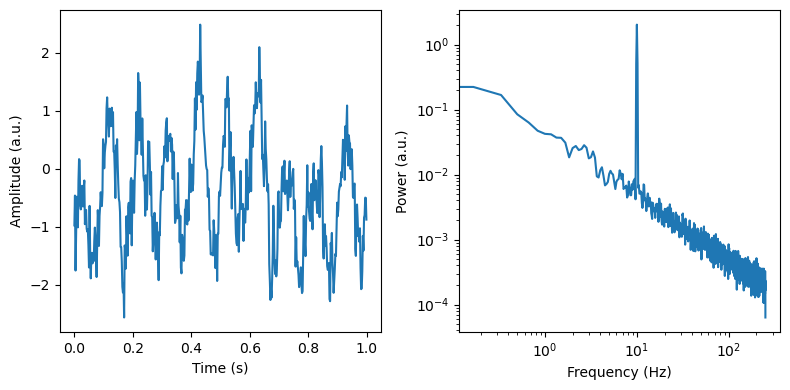

In [2]:
fs = 500
n_seconds = 60
duration=6
overlap=0.5

sim_components = {'sim_powerlaw': {'exponent' : -1}, 
                  'sim_oscillation': {'freq' : 10}}


sig = sim_combined(n_seconds=n_seconds, fs=fs, components=sim_components)
times = create_times(n_seconds=n_seconds, fs=fs)

max_times = times < 1
f, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].plot(times[max_times], sig[max_times])
axes[0].set_ylabel('Amplitude (a.u.)')
axes[0].set_xlabel('Time (s)')
freq, psd = dsp.welch(sig, fs=fs, nperseg=duration*fs, noverlap=duration*fs*overlap)
axes[1].loglog(freq, psd)
axes[1].set_ylabel('Power (a.u.)')
axes[1].set_xlabel('Frequency (Hz)')

plt.tight_layout()

## Case #1: Up-/Downsampling meets nyquist

The signal we simulated previously has a sampling rate of 500Hz. When we start evaluating data that touches or exceeds the nyquist frequency i.e. fs/2. 
We get an Error. 

In [3]:
irasa_out = irasa(sig, 
                    fs=fs, 
                    band=(1, 150), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    hset_info=(1, 2, 0.05))


AssertionError: The evaluated frequency range goes up to 300.0Hz which is higher than the Nyquist frequency for your data of 250.0Hz, 
try to either lower the upper bound for the hset or decrease the upper band limit, when running IRASA.

We can get rid of this error in 2 ways. Either we adjust the hmax and decrease it (in this example anything below 1.66 should work) or we decrease the maximally evaluated frequency (in this example any value below 125Hz)

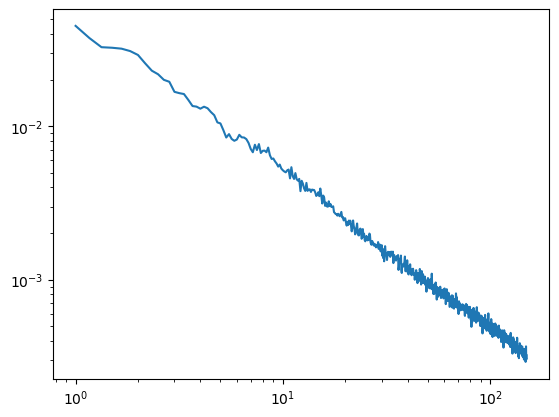

In [4]:
#hset below 2
irasa_out = irasa(sig, 
                    fs=fs, 
                    band=(1, 150), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    hset_info=(1, 1.66, 0.05))


plt.loglog(irasa_out.freqs, irasa_out.aperiodic.T)

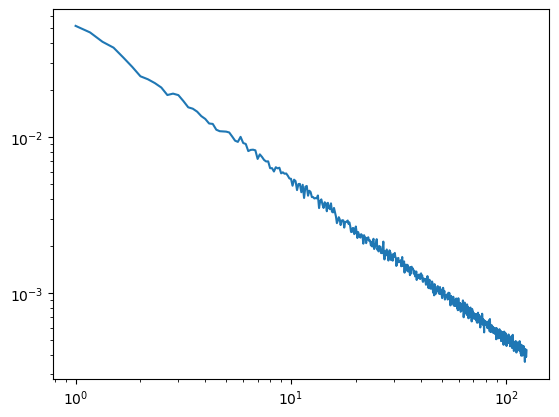

In [5]:
#band below 150
irasa_out = irasa(sig, 
                    fs=fs, 
                    band=(1, 124), 
                    psd_kwargs={'nperseg': duration*fs, 
                                'noverlap': duration*fs*overlap
                            },
                    hset_info=(1, 2, 0.05))


plt.loglog(irasa_out.freqs, irasa_out.aperiodic.T)

## Case #2: Fitting IRASA inside your high-pass and lowpass filters

In the case that our model evaluations includes the nyquist frequency, pyrasa actually throws an error as long as you specify your sampling frequency correctly (labeled as fs in pyrasa.irasa).
However, another Issue is generated by fitting your model inside your high-pass or lowpass filters. As how their data is handled is up to every researcher before applying IRASA, 
exact filter specifications are not always available, hence pyrasa does not per default recognize whether your data has been filtered or not. If you use the `pyrasa.irasa_mne` this is taken into account as mne stores filter information in the raw or epoched object. In order to illustrate what happens when you accidently fit in your filters see below.. what happens to our aperiodic spectrum in high and low pass filtered signals..

,Offset,Exponent,fit_type,ch_name
0,-3.470763,-0.272755,fixed,0


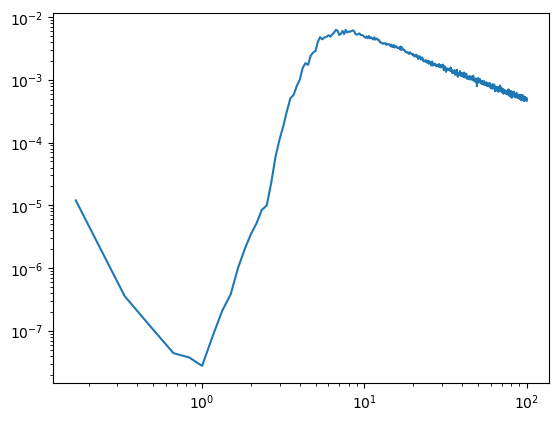

In [5]:
from neurodsp.filt import filter_signal

sig_hp = filter_signal(sig, fs=fs, pass_type='highpass', f_range=(4, None))
sig_hp = sig_hp[~np.isnan(sig_hp)]

irasa_out = irasa(sig_hp, 
                    fs=fs, 
                    band=(.1, 100), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    hset_info=(1, 2, 0.05))

plt.loglog(irasa_out.freqs, irasa_out.aperiodic.T)
irasa_out.fit_aperiodic_model().aperiodic_params

This looks clearly wrong and illustrates why our lower evaluated frequency range should never go below the high-pass filter.
In this case our hmax is 2 so taking 2 * the highpass filter edge is giving us the lowest point that we can sensibly evaluate (i.e. 8Hz)

,Offset,Exponent,fit_type,ch_name
0,-1.281976,1.019193,fixed,0


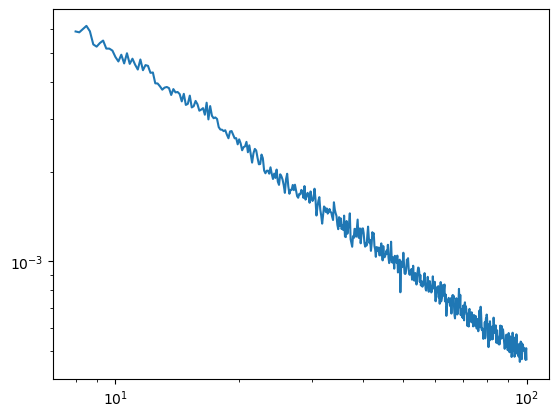

In [6]:
irasa_out = irasa(sig_hp, 
                    fs=fs, 
                    band=(8, 100), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    hset_info=(1, 2, 0.05))

plt.loglog(irasa_out.freqs, irasa_out.aperiodic.T)

irasa_out.fit_aperiodic_model().aperiodic_params

The same applies to lowpass filters. Here the upper-most evaluated frequency also depends on the lowpass edge. I.e. we want to stay below lowpass / hmax. 

,Offset,Exponent,fit_type,ch_name
0,1.741544,4.215911,fixed,0


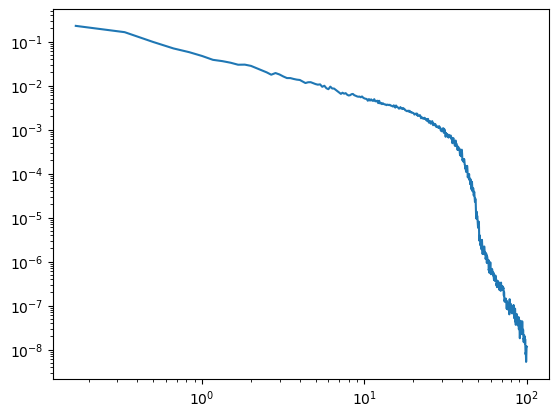

In [7]:
sig_lp = filter_signal(sig, fs=fs, pass_type='lowpass', f_range=(None, 50))
sig_lp = sig_lp[~np.isnan(sig_lp)]

irasa_out = irasa(sig_lp, 
                    fs=fs, 
                    band=(.1, 100), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    hset_info=(1, 2, 0.05))

plt.loglog(irasa_out.freqs, irasa_out.aperiodic.T)
irasa_out.fit_aperiodic_model().aperiodic_params

,Offset,Exponent,fit_type,ch_name
0,-1.279485,1.027562,fixed,0


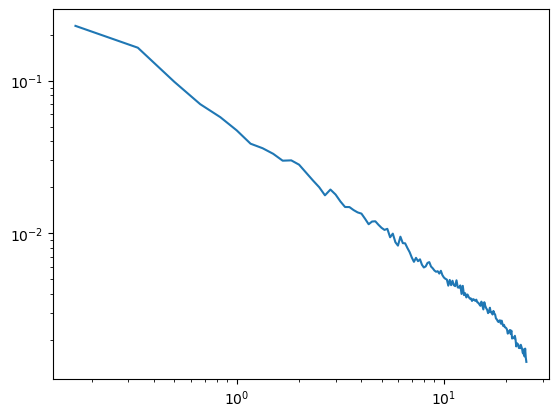

In [8]:
irasa_out = irasa(sig_lp, 
                    fs=fs, 
                    band=(.1, 25), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    hset_info=(1, 2, 0.05))

plt.loglog(irasa_out.freqs, irasa_out.aperiodic.T)
irasa_out.fit_aperiodic_model().aperiodic_params

A good way of accidently misspecifying your model is to pass the filter bounds to `pyrasa.irasa`.
Model misspecifications will result in informative error messages. 
That will tell you how to improve your irasa fit.

In [9]:
irasa_out = irasa(sig_lp, 
                    fs=fs, 
                    band=(.1, 100), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    filter_settings=(None, 50),
                    hset_info=(1, 2, 0.05))

AssertionError: You run IRASA in a frequency range from 0.05 - 200.0Hz. 
Your settings specified in "filter_settings" indicate that you have a pass band from 0.05 - 50Hz. 
This means that your evaluated range likely contains filter artifacts. 
Either change your filter settings, adjust hset or the parameter "band" accordingly. 
You want to make sure that the lower band limit divided by the upper bound of the hset > 0.05 
and that upper band limit times the upper bound of the hset < 50

In [10]:
irasa_out = irasa(sig_hp, 
                    fs=fs, 
                    band=(.1, 100), 
                    nperseg=duration*fs, 
                    noverlap=duration*fs*overlap,
                    filter_settings=(4, None),
                    hset_info=(1, 2, 0.05))

AssertionError: You run IRASA in a frequency range from 0.05 - 200.0Hz. 
Your settings specified in "filter_settings" indicate that you have a pass band from 4 - 200.0Hz. 
This means that your evaluated range likely contains filter artifacts. 
Either change your filter settings, adjust hset or the parameter "band" accordingly. 
You want to make sure that the lower band limit divided by the upper bound of the hset > 4 
and that upper band limit times the upper bound of the hset < 200.0